<a href="https://colab.research.google.com/github/ishaanalmeida/stat-arb-mean-reversion/blob/main/stat_arb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Statistical Arbitrage: Mean Reversion in Equity Pairs

In [1]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
!git clone https://github.com/ishaanalmeida/stat-arb-mean-reversion.git

Cloning into 'stat-arb-mean-reversion'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.


In [3]:
%cd stat-arb-mean-reversion

/content/stat-arb-mean-reversion


# 1. Project Overview and Hypothesis

In this individual project, I explore a Statistical Arbitrage strategy that leverages mean reversion between two closely related stocks: Visa (V) and Mastercard (MA).

Both companies operate in the digital payments industry and exhibit strong correlation due to their similar business models, market influence, and shared macroeconomic drivers. My goal is to investigate whether their price spread demonstrates stationarity over time, which would make the pair suitable for a mean-reverting long-short strategy.

To do this, I apply cointegration tests (ADF and Johansen) to assess the long-term statistical relationship between the stocks. If cointegration is present, I generate trading signals based on z-score thresholds of the spread and simulate trades using a backtesting engine. The strategy’s performance is then evaluated using metrics such as Sharpe Ratio, CAGR, and maximum drawdown.

## Hypothesis:

If Visa and Mastercard are cointegrated, then any short-term divergence in their price spread is likely to revert to a mean.

Based on this, I hypothesize that a strategy that:

*   Goes long on the undervalued stock (below spread)
*   Goes short on the overvalued stock (above spread)

…can profit when the spread returns to equilibrium.

# 2. Data Collection and Preprocessing

In [9]:
# Import dependencies
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

[*********************100%***********************]  2 of 2 completed


Ticker               V          MA
Date                              
2018-01-02  114.510002  151.910004
2018-01-03  115.650002  153.820007
2018-01-04  116.080002  155.809998
2018-01-05  118.860001  159.039993
2018-01-08  119.339996  159.270004


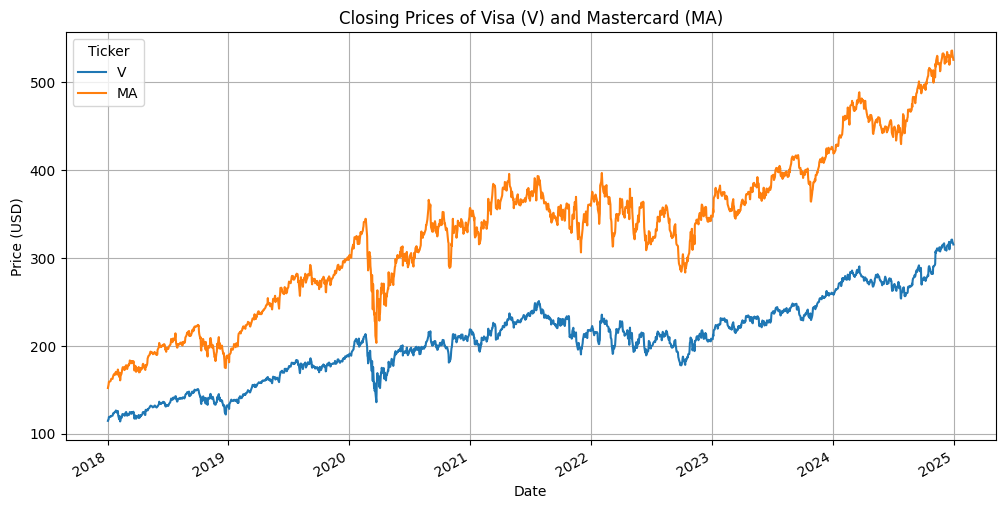

In [6]:
tickers = ['V', 'MA']
start_date = '2018-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# Extract the 'Close' prices instead of 'Adj Close'
close_prices = data['Close'][tickers]

# Drop missing values
close_prices.dropna(inplace=True)

# Preview the data
print(close_prices.head())

# Plot both price series
close_prices.plot(figsize=(12, 6), title='Closing Prices of Visa (V) and Mastercard (MA)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


# 3. Cointegration Testing (ADF + Johansen)

Hedge ratio (beta) V~MA: 0.8221  | Intercept: 0.5604

Engle–Granger ADF on residuals
ADF stat: -5.340 | p-value: 0.0000
Critical values: {'1%': np.float64(-3.4340922388213175), '5%': np.float64(-2.863192990001633), '10%': np.float64(-2.5676500029387754)}

Johansen (trace) test vs 5% critical values
r <= 0: trace=33.32  | 5% crit=15.49
r <= 1: trace=2.85  | 5% crit=3.84


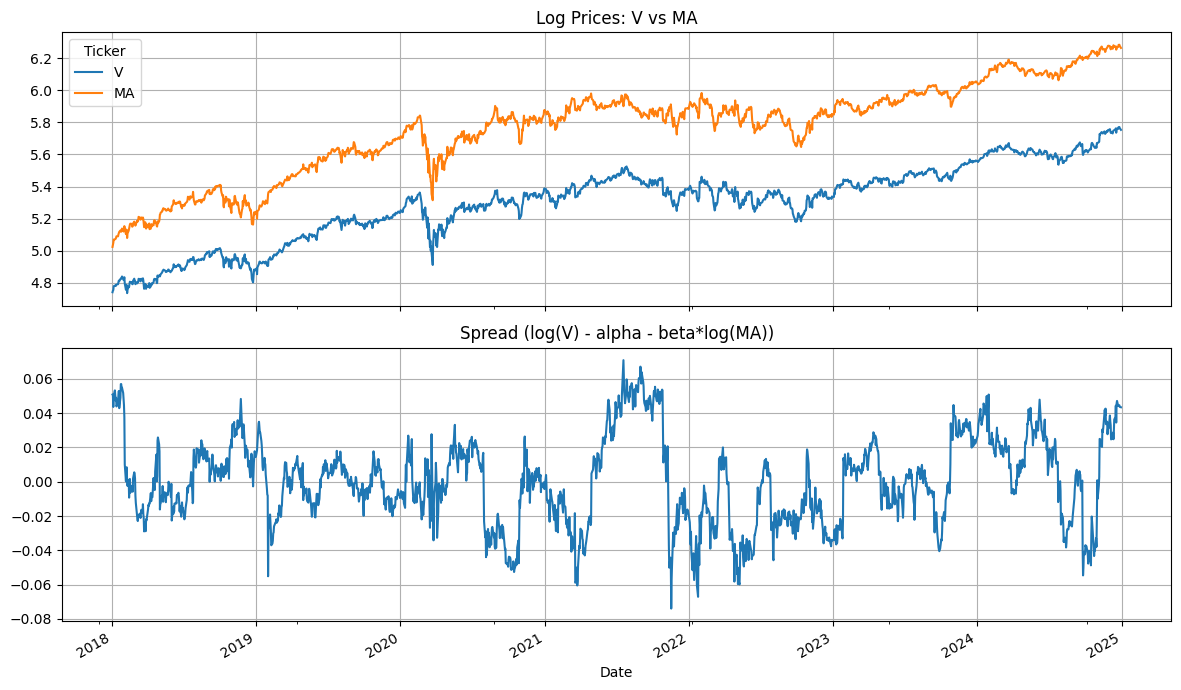


Estimated half-life (days): 17.1


In [10]:
# Use the close_prices DataFrame you already created
df = close_prices.dropna().copy()

# Work in log prices (standard for pairs)
log_df = np.log(df[['V','MA']])

# 1) Engle–Granger: regress V on MA to get hedge ratio and residual (spread)
y = log_df['V']
X = sm.add_constant(log_df['MA'])
eg_model = sm.OLS(y, X).fit()
alpha = eg_model.params['const']
beta  = eg_model.params['MA']

spread = y - (alpha + beta*log_df['MA'])
spread.name = 'spread'

print(f"Hedge ratio (beta) V~MA: {beta:.4f}  | Intercept: {alpha:.4f}")

# ADF on residuals (key test for cointegration)
adf_stat, pval, usedlag, nobs, crit, icbest = adfuller(spread.dropna())
print("\nEngle–Granger ADF on residuals")
print(f"ADF stat: {adf_stat:.3f} | p-value: {pval:.4f}")
print(f"Critical values: {crit}")

# 2) Johansen test (multivariate check)
jres = coint_johansen(log_df[['V','MA']], det_order=0, k_ar_diff=1)
trace_stats = jres.lr1        # trace statistics
crit_vals   = jres.cvt[:,1]   # 5% critical values
print("\nJohansen (trace) test vs 5% critical values")
for i, (ts, cv) in enumerate(zip(trace_stats, crit_vals)):
    print(f"r <= {i}: trace={ts:.2f}  | 5% crit={cv:.2f}")

# Quick visuals
fig, ax = plt.subplots(2,1,figsize=(12,7), sharex=True)
log_df.plot(ax=ax[0], title='Log Prices: V vs MA')
spread.plot(ax=ax[1], title='Spread (log(V) - alpha - beta*log(MA))')
ax[0].grid(True); ax[1].grid(True)
plt.tight_layout(); plt.show()

# Optional: estimate half-life to guide rolling window later
spread_lag = spread.shift(1)
delta = spread - spread_lag
df_hl = pd.concat([delta, spread_lag], axis=1).dropna()
df_hl.columns = ['delta','lag']
hl_model = sm.OLS(df_hl['delta'], sm.add_constant(df_hl['lag'])).fit()
phi = hl_model.params['lag']            # in Δspread = c + φ * spread_{t-1} + ε
halflife = -np.log(2)/np.log(1 + phi) if (1+phi) > 0 else np.nan
print(f"\nEstimated half-life (days): {halflife:.1f}")

# 4. Z-score Calculation and Entry/Exit Logic

In [30]:
# --- 4.0b: Rolling OLS beta (lagged) + blend with constant beta ---
import numpy as np, pandas as pd, statsmodels.api as sm

win = 120      # try 90/120/180 later
lam = 0.5      # blend weight: 0 = pure constant beta, 1 = pure rolling beta

logp = np.log(close_prices[['V','MA']])
idx = logp.index
const = pd.Series(1.0, index=idx, name='const')

alphas, betas = [], []
for i in range(len(idx)):
    if i < win:
        alphas.append(np.nan); betas.append(np.nan); continue
    y = logp['V'].iloc[i-win+1:i+1]
    X = pd.concat([const.iloc[i-win+1:i+1], logp['MA'].iloc[i-win+1:i+1]], axis=1)
    res = sm.OLS(y, X).fit()
    alphas.append(res.params['const']); betas.append(res.params['MA'])

alpha_rb = pd.Series(alphas, index=idx, name='alpha_rb')
beta_rb  = pd.Series(betas,  index=idx, name='beta_rb')

# Constant beta from Engle–Granger (already computed earlier as `beta`)
beta_const = pd.Series(beta, index=idx, name='beta_const')

# Blend & LAG by 1 bar for trading (use beta estimated up to t-1 for returns at t)
beta_blend = (lam * beta_rb + (1 - lam) * beta_const).shift(1)

# Build spread with the **non-lagged** alpha/beta for z-score construction (information up to t)
# and then align start where both alpha_rb & beta_rb exist
spread_blend = logp['V'] - (alpha_rb + (lam * beta_rb + (1 - lam) * beta_const) * logp['MA'])
valid_start = max(spread_blend.first_valid_index(), beta_blend.first_valid_index())
spread_blend = spread_blend.loc[valid_start:]
beta_blend   = beta_blend.loc[valid_start:]

print(f"Blended beta ready from {valid_start.date()} | lam={lam}, window={win}")

λ=0.25, win=90 -> Sharpe 0.49
λ=0.25, win=120 -> Sharpe 0.48
λ=0.25, win=180 -> Sharpe -0.03
λ=0.5, win=90 -> Sharpe 0.51
λ=0.5, win=120 -> Sharpe 0.52
λ=0.5, win=180 -> Sharpe 0.04
λ=0.75, win=90 -> Sharpe 0.55
λ=0.75, win=120 -> Sharpe 0.32
λ=0.75, win=180 -> Sharpe -0.06


[BLENDED] win=180, λ=0.75 | lookback=60, z_entry=1.8, z_exit=0.7
Sharpe (net): 0.52 | CAGR: 3.55% | MaxDD: -7.71%


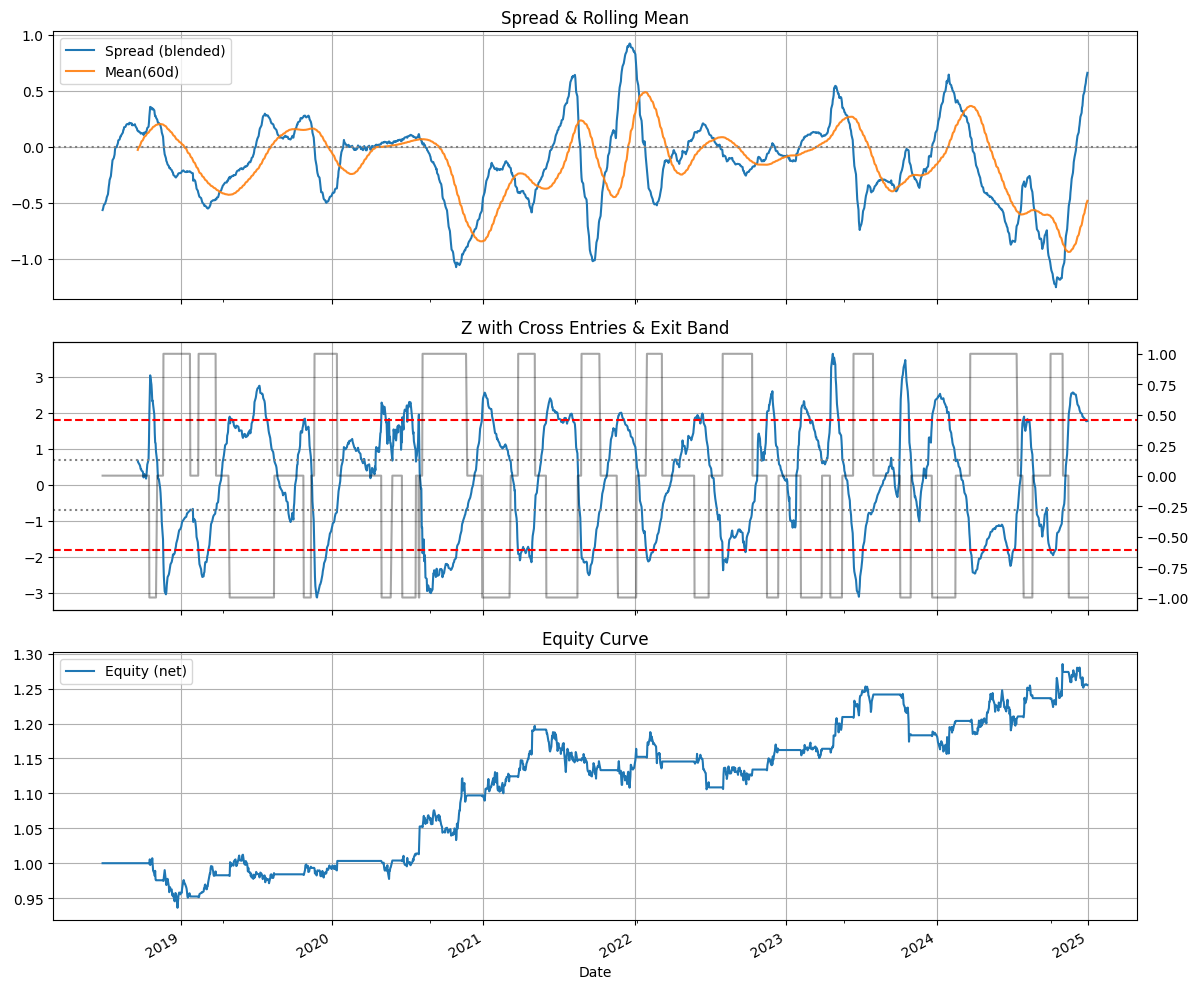

In [31]:
# --- 4.1 FINAL: Signals + Backtest (uses rolling beta/spread if available) ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Choose adaptive series if present; else fall back to constant beta setup
if 'spread_blend' in globals() and 'beta_blend' in globals() and not spread_blend.dropna().empty:
    spread_use = spread_blend.copy()
    beta_use   = beta_blend.copy()
else:
    spread_use = spread.copy()
    beta_use   = pd.Series(beta, index=np.log(close_prices[['V','MA']]).index).shift(1)  # lag constant beta 1 bar for symmetry
    spread_use = spread_use.loc[beta_use.first_valid_index():]
    beta_use   = beta_use.loc[spread_use.index[0]:]

# Params (your tuned values)
lookback     = 60
z_entry      = 1.8
z_exit       = 0.7
cost_per_leg = 0.0005

# Rolling z-score on the chosen spread
m = spread_use.rolling(lookback).mean()
s = spread_use.rolling(lookback).std()
z = (spread_use - m) / s
z = z.replace([np.inf, -np.inf], np.nan)

# Cross-entry, fixed sizing
pos = pd.Series(0.0, index=z.index, name='position')
for i in range(1, len(z)):
    zprev, znow = z.iloc[i-1], z.iloc[i]
    cur = pos.iloc[i-1]; new = cur
    if cur != 0.0:
        if abs(znow) < z_exit: new = 0.0
    else:
        if (zprev <  z_entry) and (znow >=  z_entry): new = -1.0
        elif (zprev > -z_entry) and (znow <= -z_entry): new = +1.0
    pos.iloc[i] = new

# Returns with matched/lagged beta
logr = np.log(close_prices[['V','MA']]).diff()
logr  = logr.loc[z.index[0]:]                # align
beta_use = beta_use.reindex(logr.index).ffill()
spread_ret = logr['V'] - beta_use * logr['MA']

# PnL
p_ret_gross = pos.shift(1).reindex(spread_ret.index).fillna(0.0) * spread_ret
turnover    = pos.reindex(spread_ret.index).diff().abs().fillna(0.0)
p_ret_net   = p_ret_gross - turnover * (2 * cost_per_leg)
equity      = (1 + p_ret_net.fillna(0.0)).cumprod()

# Metrics
ann = 252
def sharpe(ser):
    mu, sd = ser.mean(), ser.std(ddof=0)
    return np.sqrt(ann)*(mu/sd) if sd>0 else np.nan
def cagr(eq):
    years = (eq.index[-1]-eq.index[0]).days/365.25
    return (eq.iloc[-1])**(1/years)-1 if years>0 else np.nan
def max_dd(eq):
    dd = eq/eq.cummax()-1.0
    return dd.min(), dd

SR = sharpe(p_ret_net.dropna()); CAGR = cagr(equity); MDD, _ = max_dd(equity)
print(f"[BLENDED] win={win}, λ={lam} | lookback={lookback}, z_entry={z_entry}, z_exit={z_exit}")
print(f"Sharpe (net): {SR:.2f} | CAGR: {CAGR:.2%} | MaxDD: {MDD:.2%}")

# Plots
fig, ax = plt.subplots(3,1,figsize=(12,10), sharex=True)
spread_use.plot(ax=ax[0], label='Spread (blended)' if 'spread_blend' in globals() else 'Spread')
m.plot(ax=ax[0], label=f'Mean({lookback}d)', alpha=0.9)
ax[0].axhline(0, ls=':', c='gray'); ax[0].legend(); ax[0].grid(True); ax[0].set_title('Spread & Rolling Mean')

z.plot(ax=ax[1], label='Z-score')
for h in [z_entry,-z_entry,z_exit,-z_exit]:
    ax[1].axhline(h, ls='--' if abs(h)==z_entry else ':', c='red' if abs(h)==z_entry else 'gray')
pos.plot(ax=ax[1], secondary_y=True, color='black', alpha=0.35, label='Position')
ax[1].grid(True); ax[1].set_title('Z with Cross Entries & Exit Band')

equity.plot(ax=ax[2], label='Equity (net)'); ax[2].grid(True); ax[2].legend(); ax[2].set_title('Equity Curve')
plt.tight_layout(); plt.show()


In [32]:
# --- 4.2c: Completed-trade diagnostics (robust) ---
# Uses `pos` and `p_ret_net` from 4.1/4.1b

import numpy as np
import pandas as pd

# Identify entries (0 -> nonzero) and exits (nonzero -> 0)
entry_sig = (pos.shift(1).fillna(0) == 0) & (pos != 0)
exit_sig  = (pos.shift(1) != 0) & (pos == 0)

entries = pos.index[entry_sig]
exits   = pos.index[exit_sig]

# If an exit occurs before the first entry, drop that first exit
if len(exits) and len(entries) and exits[0] <= entries[0]:
    exits = exits[1:]

# Align pairs and drop any trailing open trade
n = min(len(entries), len(exits))
entries = entries[:n]
exits   = exits[:n]

trade_pnls = []
trade_sides = []
trade_holds = []

idx = p_ret_net.index
for s, e in zip(entries, exits):
    # Because we trade on the next bar (pos.shift(1)), PnL starts the bar AFTER entry.
    s_i = idx.get_indexer([s])[0] + 1
    e_i = idx.get_indexer([e])[0]      # include the exit bar (contains exit cost)
    if s_i <= e_i:
        seg = p_ret_net.iloc[s_i:e_i+1]
        trade_pnls.append(seg.sum())
        trade_holds.append(len(seg))
        trade_sides.append(np.sign(pos.loc[s]))

trade_pnls = pd.Series(trade_pnls, index=range(len(trade_pnls)))
trade_holds = pd.Series(trade_holds, index=trade_pnls.index)
trade_sides = pd.Series(trade_sides, index=trade_pnls.index)

print(f"Completed trades: {len(trade_pnls)}")
if len(trade_pnls):
    print(f"Win rate: {(trade_pnls > 0).mean():.1%}")
    print(f"Avg hold: {trade_holds.mean():.1f} days | Median: {trade_holds.median():.0f} days")
    print(f"Avg trade PnL (net): {trade_pnls.mean():.5f} | Median: {trade_pnls.median():.5f}")
    print(f"Long/Short mix: { (trade_sides>0).mean():.1%} long-spread, {(trade_sides<0).mean():.1%} short-spread")

Completed trades: 27
Win rate: 74.1%
Avg hold: 33.0 days | Median: 29 days
Avg trade PnL (net): 0.01058 | Median: 0.01130
Long/Short mix: 40.7% long-spread, 59.3% short-spread


In [26]:
# --- 4.3 QUICK WIN: Cost sensitivity ---
cost_grid = [0.0000, 0.0002, 0.0005, 0.0010]  # 0, 2, 5, 10 bps per leg
for c in cost_grid:
    p = (pos.shift(1).reindex(spread_ret.index).fillna(0.0) * spread_ret) \
        - pos.reindex(spread_ret.index).diff().abs().fillna(0.0) * (2*c)
    sh = np.sqrt(252) * p.mean() / p.std()
    print(f"Costs {int(c*1e4)} bps/leg -> Sharpe {sh:.2f}")


Costs 0 bps/leg -> Sharpe 0.64
Costs 2 bps/leg -> Sharpe 0.59
Costs 5 bps/leg -> Sharpe 0.52
Costs 10 bps/leg -> Sharpe 0.40


In [33]:
fig.savefig('fig_spread_mean.png', dpi=180, bbox_inches='tight')
plt.close(fig)

# 5. Backtesting the Strategy

# 6. Performance Evaluation (PnL, Sharpe, Drawdown)


# 7. Visualization

# 8. Observations and Next Steps